In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm

import pickle

from epimodel.pymc3_models.cm_effect.datapreprocessor import DataPreprocessor
from os import walk

import re

from matplotlib.font_manager import FontProperties
fp2 = FontProperties(fname=r"../../fonts/Font Awesome 5 Free-Solid-900.otf")

setting environment variables properly now done.


In [4]:
dp = DataPreprocessor(drop_HS=True)
data = dp.preprocess_data("double_entry_final.csv", last_day="2020-05-30", schools_unis="lol")

INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Travel Screen/Quarantine
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Travel Bans
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Public Transport Limited
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Internal Movement Limited
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Public Information Campaigns
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Symptomatic Testing
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Performing Smoothing
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Albania
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Georgia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Iceland
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Latvia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing New Zealand
IN

In [ ]:
default_res = pickle.load(open("final_full.pkl", "rb")).CMReduction

In [5]:
exp_dir = "../../server/additional_exps"

def load_exp(exp_num, local=False):
    if not local:
        return pickle.load(open(f"{exp_dir}/exp_{exp_num}.pkl", "rb"))
    else:
        return pickle.load(open(f"../../additional_exps/exp_{exp_num}.pkl", "rb"))

colors = [*sns.color_palette("colorblind"), *sns.color_palette("bright")]

In [ ]:
derived_features = [ #()"Healthcare Infection Control", [0]),
 ("Mask-wearing mandatory in\n(some) public spaces", [0]),
 ("Gatherings limited to 1000\npeople or less", [1]),
 ("Gatherings limited to 100\npeople or less", [2, 1]),
 ("Gatherings limited to 10\npeople or less", [3, 2, 1]),
 ("Some businesses closed", [4]),
 ("Most businesses closed", [4, 5]),
 ("Schools and universities closed", [6, 7]),
 ("Stay-at-home order\n(with exemptions)", [8]),
 ]


# derived_features = [ #()"Healthcare Infection Control", [0]),
#  ("Mask-wearing mandatory in\n(some) public spaces", [0]),
#  ("Gatherings limited to 1000\npeople or less", [1]),
#  ("Gatherings limited to 100\npeople or less", [2]),
#  ("Gatherings limited to 10\npeople or less", [3]),
#  ("Some businesses closed", [4]),
#  ("Most businesses closed", [5]),
#  ("Schools and universities closed", [6, 7]),
#  ("Stay-at-home order\n(with exemptions)", [8]),
#  ]

cm_plot_style = [
#             ("\uf7f2", "tab:red"), # hospital symbol
            ("\uf963", "black"), # mask
            ("\uf0c0", "darkgrey"), # ppl
            ("\uf0c0", "dimgrey"), # ppl
            ("\uf0c0", "black"), # ppl
            ("\uf07a", "tab:orange"), # shop 1
            ("\uf07a", "tab:red"), # shop2
            ("\uf549", "black"), # school
            ("\uf19d", "black"), # university
            ("\uf965", "black") # home
]

def produce_ranges(trace):
    means = np.mean(trace, axis=0)
    med = np.median(trace, axis=0)
    li = np.percentile(trace, 2.5, axis=0)
    ui = np.percentile(trace, 97.5, axis=0)
    lq = np.percentile(trace, 25, axis=0)
    uq = np.percentile(trace, 75, axis=0)
    return means, med, li, ui, lq, uq

def add_trace_to_plot(res, y_off, col, label, alpha, width, size=8, zeros=None):
    nS, _ = res.shape
    nF = len(derived_features)
    derived_samples = np.zeros((nS, nF))

    for f_i, (f, prodrows) in enumerate(derived_features):
        samples = np.ones(nS)
        for r in prodrows:
            samples = samples * res[:, r] 
        derived_samples[:, f_i] = samples

    res = derived_samples
    res = 100*(1-res)
    
    if zeros is not None:
        for z in zeros:
            if z < nF:
                res[:, z] = 1e5
    
    y_vals = -1 * np.arange(nF)
    plt.plot([100], [100], color=col, linewidth=1, alpha=alpha, label=label)
    mn, med, li, ui, lq, uq = produce_ranges(res)
    plt.scatter(med, y_vals+y_off, marker="|", color=col, s=size, alpha=alpha)
    for cm in range(nF):
        if cm > 7:
            plt.plot([li[cm], ui[cm]], [y_vals[cm]+y_off, y_vals[cm]+y_off], color=col, alpha=alpha*0.25*0.25, linewidth=width, linestyle="--")
            plt.plot([lq[cm], uq[cm]], [y_vals[cm]+y_off, y_vals[cm]+y_off], color=col, alpha=alpha*0.75*0.25, linewidth=width, linestyle="--")
        else:
            plt.plot([li[cm], ui[cm]], [y_vals[cm]+y_off, y_vals[cm]+y_off], color=col, alpha=alpha*0.25, linewidth=width)
            plt.plot([lq[cm], uq[cm]], [y_vals[cm]+y_off, y_vals[cm]+y_off], color=col, alpha=alpha*0.75, linewidth=width)
        
def setup_large_plot(y_ticks = True, icons = True, xlabel=True):
    nF = len(derived_features)
    ax = plt.gca()
    x_min = -50
    x_max = 100
    plt.plot([0, 0], [1, -(nF)], "--k", linewidth=0.5)
    xrange = np.array([x_min, x_max])
    for height in range(0, nF+2, 2):
        plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="silver", alpha=0.5, linewidth=0)
    xtick_vals = [-50, -25, 0, 25, 50, 75, 100]
    xtick_str = [f"{x:.0f}%" for x in xtick_vals]
    if y_ticks:
        plt.yticks(-np.arange(nF), [f"{f[0]}" for f in derived_features], fontsize=8, ha="left")
        yax = ax.get_yaxis()
        yax.set_tick_params(pad=140)
        
    else:
        plt.yticks([])
    x_r = np.abs(x_min - x_max)
    plt.xticks(xtick_vals, xtick_str, fontsize=8)
    plt.xlim([x_min, x_max])
    plt.ylim([-(nF - 0.25), 0.75])
    
    if icons:
        for cm in range(len(derived_features)):
            for i, val in enumerate(derived_features[cm][1]):
                plt.text(x_min - 7.5 - 8*i, -cm, cm_plot_style[val][0], horizontalalignment='center', verticalalignment='center',
                             fontproperties=fp2, fontsize=8, color=cm_plot_style[val][1], zorder=-i, alpha = 1) 
                
    if xlabel:
        plt.xlabel("Average additional reduction in $R$, in the context of our data", fontsize=8)
        
def setup_larger_plot(y_ticks = True, icons = True, xlabel=True):
    nF = len(derived_features)
    ax = plt.gca()
    x_min = -50
    x_max = 100
    plt.plot([0, 0], [1, -(nF)], "--k", linewidth=0.5)
    xrange = np.array([x_min, x_max])
    for height in range(0, nF+2, 2):
        plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="silver", alpha=0.5, linewidth=0)
    xtick_vals = [-50, -25, 0, 25, 50, 75, 100]
    xtick_str = [f"{x:.0f}%" for x in xtick_vals]
    if y_ticks:
        plt.yticks(-np.arange(nF), [f"{f[0]}" for f in derived_features], fontsize=8, ha="left")
        yax = ax.get_yaxis()
        yax.set_tick_params(pad=140)
        
    else:
        plt.yticks([])
    x_r = np.abs(x_min - x_max)
    plt.xticks(xtick_vals, xtick_str, fontsize=8)
    plt.xlim([x_min, x_max])
    plt.ylim([-(nF - 0.25), 0.75])
    
    if icons:
        for cm in range(len(derived_features)):
            for i, val in enumerate(derived_features[cm][1]):
                plt.text(x_min - 7.5 - 9*i, -cm, cm_plot_style[val][0], horizontalalignment='center', verticalalignment='center',
                             fontproperties=fp2, fontsize=12, color=cm_plot_style[val][1], zorder=-i, alpha = 1) 
                
    if xlabel:
        plt.xlabel("Average additional reduction in $R$, in the context of our data", fontsize=8)
    
def setup_small_plot(y_ticks = True, icons = True, xlabel=True):
    nF = len(derived_features)
    ax = plt.gca()
    x_min = -50
    x_max = 100
    plt.plot([0, 0], [1, -(nF)], "--k", linewidth=0.5)
    xrange = np.array([x_min, x_max])
    for height in range(0, nF+2, 2):
        plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="silver", alpha=0.5, linewidth=0)
    xtick_vals = [-50, 0, 50, 100]
    xtick_str = [f"{x:.0f}%" for x in xtick_vals]
    if y_ticks:
        plt.yticks(-np.arange(nF), [f"{f[0]}" for f in derived_features], fontsize=8, ha="left")
        yax = ax.get_yaxis()
        yax.set_tick_params(pad=140)
        
    else:
        plt.yticks([])
    x_r = np.abs(x_min - x_max)
    plt.xticks(xtick_vals, xtick_str, fontsize=8)
    plt.xlim([x_min, x_max])
    plt.ylim([-(nF - 0.25), 0.75])
    
    if icons:
        for cm in range(len(derived_features)):
            for i, val in enumerate(derived_features[cm][1]):
                plt.text(x_min - 7.5 - 13*i, -cm, cm_plot_style[val][0], horizontalalignment='center', verticalalignment='center',
                             fontproperties=fp2, fontsize=8, color=cm_plot_style[val][1], zorder=-i, alpha = 1) 
                
    if xlabel:
        plt.xlabel("Average additional reduction in $R$, in the context of our data", fontsize=8)
        
class ResultsObject():
    def __init__(self, indx, trace):
        self.CMReduction = trace.CMReduction
        self.RegionR = trace.RegionR[:, indx]
        self.InfectedCases = trace.InfectedCases[:, indx, :]
        self.InfectedDeaths = trace.InfectedDeaths[:, indx, :]
        self.ExpectedCases = trace.ExpectedCases[:, indx, :]
        self.ExpectedDeaths = trace.ExpectedDeaths[:, indx, :]

In [ ]:
from collections import defaultdict

nCMs = 9

def grab_traces_categorised(fname, verbose=False):
    global default_res
    
    files_found = 0
    all_traces = []
    cat_sen = defaultdict(list)
    for i, (dirpath, dirnames, filenames) in enumerate(walk(fname)):
        for f in filenames:
            if "_combined" in f and ".txt" in f and "rhat" not in f and "ess" not in f and "base" not in f:
                    
                trace = np.loadtxt(dirpath+"/"+f)
                nS, f_nCMs = trace.shape
                
                if f_nCMs > nCMs:
                    trace = trace[:, :nCMs]
                elif f_nCMs < nCMs:
                    leaveout_num = int(f[-5])
                    full_trace = np.zeros((nS, nCMs))
                    full_trace[:, :leaveout_num] = trace[:, :leaveout_num]
#                     full_trace[:, leaveout_num] = default_res[:, leaveout_num]
                    full_trace[:, leaveout_num] = np.ones(nS)
                    full_trace[:, (leaveout_num+1):] = trace[:, leaveout_num:]
                    trace = full_trace
                
                files_found += 1
                
                res = trace
                    
                if "additive" in fname:
                    res = 1 - res
                    
                if "delay_mean_death" in f: 
                    cat_sen["Death Delay"].append((f, res))
                    files_found += 1
                
                    if verbose:
                        print(f"delays added {f}")
                
                elif  "delay_mean_confirmed" in f: 
                    cat_sen["Cases Delay"].append((f, res))
                    files_found += 1
                
                    if verbose:
                        print(f"delays added {f}")
                    
                elif "serial_int" in f: 
                    cat_sen["Serial Interval"].append((f, res))
                    files_found += 1
                    
                    if verbose:
                        print(f"si added {f}")
                    
                elif "leavout" in f: 
                    cat_sen["NPI Leaveouts"].append((f, res))
                    files_found += 1
                    
                    if verbose:
                        print(f"leavouts added {f}")
                
                elif "R_hyperprior" in f: 
                    cat_sen["R Priors"].append((f, res))
                    files_found += 1
                    
                    if verbose:
                        print(f"epi prior {f}")
                        
                elif "cm_prior" in f: 
                    cat_sen["NPI Priors"].append((f, res))
                    files_found += 1
                    
                    if verbose:
                        print(f"epi prior {f}")
                        
                elif "noise" in f and "no_noise" not in f: 
                    cat_sen["Hyperparameter"].append((f, res))
                    files_found += 1
                    
                    if verbose:
                        print(f"hypers added {f}")
                        
                elif "regions_heldout" in f or "regholdout" in f: 
                    cat_sen["Region Holdouts"].append((f, res))
                    files_found += 1
                    
                    if verbose:
                        print(f"reg holdouts added {f}")
                    
                elif "schools" in f: 
                    cat_sen["SE Schools"].append((f, res))
                    files_found += 1
                    
                    if verbose:
                        print(f"mob added {f}")
                    
                elif "min_confirmed" in f: 
                    cat_sen["Minimum Confirmed Cases"].append((f, res))
                    files_found += 1
                    
                    if verbose:
                        print(f"min conf added {f}")
                        
                elif "min_deaths" in f: 
                    cat_sen["Minimum Deaths"].append((f, res))
                    files_found += 1
                    
                    if verbose:
                        print(f"min deaths added {f}")
                        
                elif "smoothing" in f: 
                    cat_sen["Smoothing"].append((f, res))
                    files_found += 1
                    
                    if verbose:
                        print(f"smooting {f}")
                
                elif "mobility" in f: 
                    cat_sen["Mobility"].append((f, res))
                    files_found += 1
                    
                    if verbose:
                        print(f"min conf added {f}")
                else:
                    print(f"File {f} not added - no category found")
        
    return cat_sen

def fname_to_label(f):
    if "regholdout" in f:
        return f[:2]
    
    if "regions_heldout" in f:
        return f[16:18]
    
    if "cm_prior" in f:
        if "wide" in f:
            return "Wide"
        
        if "half_normal" in f:
            return "Half Normal"
        
        if "icl" in f:
            return "Flaxman et. al."
    
    if "data_mobility" in f:
        if "no_work" in f:
            return "Retail & Recreation"
        elif "rec_work" in f:
            return "Workplace & Retail &\nRecreation"
    
    if "R_hyperprior" in f:
        if "0" in f:
            return "$\mu=2.5$"
        elif "1" in f:
            return "$\mu=4.5$"
    
    if "schools_open" in f:
        return "SE Schools Open"

    if "delay" in f and "confirmed" in f:
         if "0" in f:
            return "$-4$ days"
         if "1" in f:
            return "$-2$ days" 
         if "2" in f:
            return "$+2$ days" 
         if "3" in f and "v3" not in f:
            return "$+4$ days" 
    
    if "delay" in f and "death" in f:
         if "0" in f:
            return "$-4$ days"
         if "1" in f:
            return "$-2$ days" 
         if "2" in f:
            return "$+2$ days" 
         if "3" in f and "v3" not in f:
            return "$+4$ days" 

    if "cm_leavout" in f:
        if "0" in f:
            return "Mask Wearing"
        if "1" in f:
            return "Gatherings <1000"
        if "2" in f and "v3" not in f:
            return "Gatherings <100"
        if "3" in f:
            return "Gatherings <10"
        if "4" in f:
            return "Some Businesses Suspended"
        if "5" in f:
            return "Most Businesses Suspended"
        if "6" in f:
            return "School Closure"
        if "7" in f:
            return "University Closure"
        if "8" in f:
            return "Stay at Home Order"
        
    if "serial_int" in f:
        if "SI4" in f:
            return "$\mu=4$"
        if "SI5" in f:
            return "$\mu=5$"
        if "SI6" in f:
            return "$\mu=6$"
        if "SI7" in f:
            return "$\mu=7$"
        if "SI8" in f:
            return "$\mu=8$"
    
    if "min_confirmed" in f:
        if "v3" in f:
            val = re.findall('\\d+', f)[1]
        else:
            val = re.findall('\\d+', f)[0]
        return f"{val}"
    
    if "min_deaths" in f:
        if "v3" in f:
            val = re.findall('\\d+', f)[1]
        else:
            val = re.findall('\\d+', f)[0]
        return f"{val}"
    
    if "cm_prior_combined_additive" in f:
        if "10" in f:
            return "$\\alpha_i\sim$Dirichlet($\\alpha=10$)"
        if "5" in f:
            return "$\\alpha_i\sim$Dirichlet($\\alpha=5$)"
    
    if "smoothing" in f:
        if "v3" in f:
            val = re.findall('\\d+', f)[1]
        else:
            val = re.findall('\\d+', f)[0]
        return f"{val} days"
    
    if "growth_noise" in f and "0" in f:
        return "$\sigma_n=0.05$"
    
    if "growth_noise" in f and "1" in f:
        return "$\sigma_n=0.1$"
    
    if "growth_noise" in f and "2" in f:
        return "$\sigma_n=0.4$"
    
    return f

In [ ]:
cat_sen = grab_traces_categorised("../../server/traces")

# Category 1: Structural Sensitivity

In [ ]:
exp_add = 1
exp_noisyr = 2
exp_diff = 3
exp_dr = 4

res_add = load_exp(exp_add)
res_noisyr = load_exp(exp_noisyr, local=True)
res_diff = load_exp(exp_diff)
res_dr = load_exp(exp_dr)

In [ ]:
fig = plt.figure(figsize=(4, 3), dpi=300)

setup_large_plot()

y_off = -np.linspace(-0.3, 0.3, 5)
width = 1
add_trace_to_plot(1-res_add.CMReduction, y_off[0], colors[0], "Additive", 1, width) 
add_trace_to_plot(res_noisyr.CMReduction, y_off[1], colors[1], "Noisy-R", 1, width) 
add_trace_to_plot(res_diff.CMReduction, y_off[2], colors[2], "Different Effects", 1, width)
add_trace_to_plot(res_dr.CMReduction, y_off[3], colors[3], "Discrete Renewal", 1, width)
add_trace_to_plot(default_res, y_off[4], "k", "Default", 1, width) 
plt.legend(shadow=True, fancybox=True, loc="upper right", bbox_to_anchor=(1.2, 1.01), fontsize=6)
plt.title("Structural Sensitivity", fontsize="10")

plt.savefig(f"FigSSAMain.pdf", bbox_inches='tight')

# Category 2: Unobserved Effects

In [ ]:
exp_travel = 5
exp_transport = 6
exp_int_movement = 7
exp_info = 8
exp_testing = 9

exp_schools_uni = 20


res_travel = load_exp(exp_travel)
res_transport = load_exp(exp_transport)
res_int_movement = load_exp(exp_int_movement)
res_info = load_exp(exp_info)
res_testing = load_exp(exp_testing)

res_su = load_exp(exp_schools_uni, True)

In [ ]:
fig = plt.figure(figsize=(10, 3), dpi=300)

plt.subplot(121)
setup_large_plot(xlabel=False)

y_off = -np.linspace(-0.3, 0.3, 6)
width = 1
add_trace_to_plot(res_travel.CMReduction[:, :9], y_off[0], colors[0], "Travel Screening/Bans", 1, width) 
add_trace_to_plot(res_transport.CMReduction[:, :9], y_off[1], colors[1], "Public Transport Limited", 1, width) 
add_trace_to_plot(res_int_movement.CMReduction[:, :9], y_off[2], colors[2], "Internal Movement Limited", 1, width)
add_trace_to_plot(res_info.CMReduction[:, :9], y_off[3], colors[3], "Public Information Campaigns", 1, width)
add_trace_to_plot(res_testing.CMReduction[:, [0, 2, 3, 4, 5, 6, 7, 8, 9]], y_off[4], colors[4], "Symptomatic Testing", 1, width)
add_trace_to_plot(default_res, y_off[5], "k", "Default", 1, width) 

plt.legend(shadow=True, fancybox=True, loc="upper right", bbox_to_anchor=(1.2, 1.01), fontsize=6)
plt.title("Inclusion of OxCGRT NPIs", fontsize="10")

plt.subplot(122)
setup_large_plot(False)


cat_sen["NPI Leaveouts"].sort(key = lambda x: x[0])

y_off = -np.linspace(-0.4, 0.4, len(cat_sen["NPI Leaveouts"])+1)

for i, (f, t) in enumerate(cat_sen["NPI Leaveouts"]):
    if i == 6 or i == 7:
        add_trace_to_plot(t, y_off[i], colors[i], fname_to_label(f), 1, width, zeros=[6, i])
    else:
        add_trace_to_plot(t, y_off[i], colors[i], fname_to_label(f), 1, width, zeros=[i])
cm_red = res_su.CMReduction
nS, _ = cm_red.shape
cm_red[:, 6] = np.ones(nS)
cm_red[:, 7] = np.ones(nS)
add_trace_to_plot(cm_red, y_off[-1], colors[-1], "School and University Closure", 1, width,  zeros=[6, 8, 9])
plt.legend(shadow=True, fancybox=True, loc="upper right", bbox_to_anchor=(1.4, 1.01), fontsize=6)
plt.legend(shadow=True, fancybox=True, loc="upper right", bbox_to_anchor=(1.4, 1.01), fontsize=6)
plt.title("Exclusion of Collected NPIs", fontsize="10")

plt.tight_layout()
plt.savefig(f"FigureUOB_main.pdf", bbox_inches='tight')

# "Main" Figure

In [ ]:
from matplotlib.gridspec import GridSpec

In [ ]:
res_ho = load_exp(17, True)

exp_active = 18
exp_death = 19

res_active = load_exp(exp_active)
res_death = load_exp(exp_death)

In [ ]:
data = dp.preprocess_data("../../notebooks/double-entry-data/double_entry_final.csv", last_day="2020-05-30",
                                  schools_unis="whoops")
data.mask_region_ends()
# and mask earlier if needed
data.mask_reopenings(n_extra=20)

In [ ]:
fig = plt.figure(figsize=(11.5, 9), dpi=300)

gs = GridSpec(4, 4, figure=fig)
ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=2, rowspan=2))

plt.plot([10**-1, 10**7], [10**-1, 10**7], "--", linewidth=0.5, color="black")
for indx, region in enumerate(data.Rs):
    
    dd = np.nonzero(data.NewDeaths.mask[indx, :])[0][0]+19
    cd = np.nonzero(data.NewCases.mask[indx, :])[0][0]+19
    
    ed = res_ho.ExpectedDeaths[:, indx, dd]
    ec = res_ho.ExpectedCases[:, indx, cd]
    dist1 = pm.NegativeBinomial.dist(mu=ed , alpha=res_ho.Phi_1)
    dist2 = pm.NegativeBinomial.dist(mu=ec , alpha=res_ho.Phi_1)
    ec_output = dist2.random()
    try:
        ed_output = dist1.random()
    except:
        print(np.sum(ed))
        print(f"error with {region}")
        print(data.NewDeaths.data[indx, -dd])
        ed_output = 1e-10

    deaths = data.NewDeaths.data[indx, dd]
    cases = data.NewCases.data[indx, cd]
    if indx == 0:
        plt.scatter(cases, np.median(ec_output), color="tab:blue", label="Cases", s=12)    
        plt.scatter(deaths, np.median(ed_output), color="tab:red", label="Deaths", s=12)

    plt.scatter(cases, np.median(ec_output), color="tab:blue", s=12)
    plt.scatter(deaths, np.median(ed_output), color="tab:red", s=12)
    plt.plot([cases, cases], [np.percentile(ec_output, 2.5), np.percentile(ec_output, 97.5)], color="tab:blue", alpha=0.25, linewidth=2)
    plt.plot([deaths, deaths], [np.percentile(ed_output, 2.5), np.percentile(ed_output, 97.5)], color="tab:red", alpha=0.25, linewidth=2)

ax = plt.gca()
ax.tick_params(axis="both", which="major", labelsize=10)
plt.xlabel("Reported", fontsize=10)
plt.ylabel("Predicted", fontsize=10)
plt.title(f"20 Day Extrapolation", fontsize=12)
plt.yscale("log")
plt.xscale("log")
plt.legend(loc="upper left", fancybox=True, shadow=True, fontsize=10)

tick_vals = np.arange(6)-1
plt.xticks(np.power(10.0, tick_vals), [f"${np.power(10.0, loc):.0f}$" if loc<2 else f"$10^{loc}$"  for loc in tick_vals], fontsize=10)
plt.yticks(np.power(10.0, tick_vals), [f"${np.power(10.0, loc):.0f}$" if loc<2 else f"$10^{loc}$"  for loc in tick_vals], fontsize=10)
plt.grid(False, which='major', axis='both')

plt.xlim([10**-1, 10**4.5])
plt.ylim([10**-1, 10**4.5])
plt.minorticks_off()

rows = [2, 3, 2, 3]
cols = [0, 0, 1, 1]

folds = [['DE', 'HU', 'FI', 'IE', 'RS', 'BE'],
         ['DK', 'GR', 'NO', 'FR', 'RO', 'MA'],
         ['ES', 'CZ', 'NL', 'CH', 'PT', 'AT'],
         ['IL', 'SE', 'IT', 'MX', 'GB', 'PL']]

class ResultsObject():
    def __init__(self, indx, trace):
        self.CMReduction = trace.CMReduction
        self.RegionLogR = trace.RegionLogR[:, indx]
        self.Z1C = trace.Z1C[:, indx, :]
        self.Z1D = trace.Z1D[:, indx, :]
        self.InfectedCases = trace.InfectedCases[:, indx, :]
        self.InfectedDeaths = trace.InfectedDeaths[:, indx, :]
        self.ExpectedCases = trace.ExpectedCases[:, indx, :]
        self.ExpectedDeaths = trace.ExpectedDeaths[:, indx, :]
    
for s_i, (r,c) in enumerate(zip(rows, cols)):
    plt.subplot(gs.new_subplotspec((r, c), colspan=1, rowspan=1))
    setup_small_plot(False, xlabel=False)
    y_off = np.linspace(-0.3, 0.3, len(folds[0]))
    for r_i, r in enumerate(folds[s_i]):
        res = pickle.load(open(f"../../server/ho_results_final4/{r}.pkl", "rb"))
        add_trace_to_plot(res.CMReduction, y_off[r_i], colors[r_i], label=r, alpha=1, width=1, size=8)
    plt.legend(fontsize=6, loc="upper left", bbox_to_anchor=(0.9, 1.04), fancybox=True, shadow=True)
    plt.title("Country Sensitivity", fontsize=8)
    
    
ax5 = plt.subplot(gs.new_subplotspec((0, 2), colspan=1, rowspan=1))
setup_small_plot(False, xlabel=False)
plt.title("Death Delay", fontsize=8)

v = cat_sen["Death Delay"]
v.sort(key=lambda x:x[0])
y_off = np.linspace(-0.4, 0.4, len(v)+1)
width=1
for j, (f, res) in enumerate(v):
    add_trace_to_plot(res, y_off[j], col=colors[j], label=fname_to_label(f), alpha=1, width=width)
add_trace_to_plot(default_res, y_off[-1], "k", "Default", 1, width)
plt.legend(fontsize=6, loc="upper left", bbox_to_anchor=(0.9, 1.04), fancybox=True, shadow=True)

ax6 = plt.subplot(gs.new_subplotspec((0, 3), colspan=1, rowspan=1))
setup_small_plot(False, xlabel=False)
plt.title("Confirmed Delay", fontsize=8)

v = cat_sen["Cases Delay"]
v.sort(key=lambda x:x[0])
y_off = np.linspace(-0.4, 0.4, len(v)+1)
width=1
for j, (f, res) in enumerate(v):
    add_trace_to_plot(res, y_off[j], col=colors[j], label=fname_to_label(f), alpha=1, width=width)
add_trace_to_plot(default_res, y_off[-1], "k", "Default", 1, width)
plt.legend(fontsize=6, loc="upper left", bbox_to_anchor=(0.9, 1.04), fancybox=True, shadow=True)

ax7 = plt.subplot(gs.new_subplotspec((1, 2), colspan=1, rowspan=1))
setup_small_plot(False, xlabel=False)
plt.title("Effectiveness Prior", fontsize=8)

v = cat_sen["NPI Priors"]
v.sort(key=lambda x:x[0])
y_off = np.linspace(-0.4, 0.4, len(v)+1)
width=1
for j, (f, res) in enumerate(v):
    add_trace_to_plot(res, y_off[j], col=colors[j], label=fname_to_label(f), alpha=1, width=width)
add_trace_to_plot(default_res, y_off[-1], "k", "Default", 1, width)
    
plt.legend(fontsize=6, loc="upper left", bbox_to_anchor=(0.9, 1.04), fancybox=True, shadow=True)


ax8 = plt.subplot(gs.new_subplotspec((1, 3), colspan=1, rowspan=1))
setup_small_plot(False, xlabel=False)
plt.title("Generation Interval", fontsize=8)

v = cat_sen["Serial Interval"]
v.sort(key=lambda x:x[0])
y_off = np.linspace(-0.4, 0.4, len(v)+1)
width=1
for j, (f, res) in enumerate(v):
    add_trace_to_plot(res, y_off[j], col=colors[j], label=fname_to_label(f), alpha=1, width=width)
add_trace_to_plot(default_res, y_off[-1], "k", "$\mu = 6.67$", 1, width)
plt.legend(fontsize=6, loc="upper left", bbox_to_anchor=(0.9, 1.04), fancybox=True, shadow=True)

ax4 = plt.subplot(gs.new_subplotspec((2, 2), colspan=2, rowspan=2))
setup_larger_plot(False)
y_off = -np.linspace(-0.2, 0.2, 3)
width = 2
add_trace_to_plot(res_active.CMReduction, y_off[0], colors[0], "Confirmed Cases", 1, width) 
add_trace_to_plot(res_death.CMReduction, y_off[1], colors[1], "Confirmed Deaths", 1, width) 
add_trace_to_plot(default_res, y_off[2], "k", "Default", 1, width)
plt.legend(shadow=True, fancybox=True, loc="upper right", bbox_to_anchor=(1.2, 1.01), fontsize=10)
plt.title("Data Source", fontsize=12)

plt.tight_layout()
plt.savefig(f"FigureMC.pdf", bbox_inches='tight')

# PIT aggregate

In [6]:
res_ho = load_exp(17, True)

data = dp.preprocess_data("../../notebooks/double-entry-data/double_entry_final.csv", last_day="2020-05-30",
                                  schools_unis="whoops")
data.mask_region_ends()
# and mask earlier if needed
data.mask_reopenings(n_extra=20)

INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Travel Screen/Quarantine
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Travel Bans
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Public Transport Limited
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Internal Movement Limited
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Public Information Campaigns
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Symptomatic Testing
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Performing Smoothing
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Albania
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Georgia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Iceland
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Latvia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing New Zealand
IN

Masking AL from 2020-04-30 00:00:00+00:00
Masking AD from 2020-05-21 00:00:00+00:00
Masking AT from 2020-05-04 00:00:00+00:00
Masking AT from 2020-05-21 00:00:00+00:00
Masking BE from 2020-05-14 00:00:00+00:00
Masking BA from 2020-05-17 00:00:00+00:00
Masking BG from 2020-05-04 00:00:00+00:00
Masking BG from 2020-05-21 00:00:00+00:00
Masking HR from 2020-04-30 00:00:00+00:00
Masking HR from 2020-05-14 00:00:00+00:00
Masking HR from 2020-05-29 00:00:00+00:00
Masking CZ from 2020-04-27 00:00:00+00:00
Masking CZ from 2020-05-14 00:00:00+00:00
Masking CZ from 2020-05-28 00:00:00+00:00
Masking DK from 2020-04-23 00:00:00+00:00
Masking DK from 2020-05-14 00:00:00+00:00
Masking FI from 2020-05-17 00:00:00+00:00
Masking FR from 2020-05-14 00:00:00+00:00
Masking GE from 2020-05-26 00:00:00+00:00
Masking GE from 2020-05-27 00:00:00+00:00
Masking DE from 2020-04-23 00:00:00+00:00
Masking DE from 2020-05-07 00:00:00+00:00
Masking DE from 2020-05-09 00:00:00+00:00
Masking GR from 2020-05-07 00:00:0

In [7]:
from scipy.stats import nbinom

In [20]:
cdf_vals_cases = np.array([])
cdf_vals_deaths = np.array([])

alpha = np.mean(res_ho.Phi_1)
nS = res_ho.Phi_1.shape 
for indx, region in enumerate(data.Rs):
    
    dd = np.nonzero(data.NewDeaths.mask[indx, :])[0][0]
    cd = np.nonzero(data.NewCases.mask[indx, :])[0][0]
    
    ed = res_ho.ExpectedDeaths[:, indx, dd:dd+19]
    ec = res_ho.ExpectedCases[:, indx, cd:cd+19]
    deaths = data.NewDeaths.data[indx, dd:dd+19]
    cases = data.NewCases.data[indx, cd:cd+19]

    expected_deaths = ed
    mu = expected_deaths
    alpha = 60    
    p = alpha / (alpha + mu)
    cdf = nbinom.cdf(deaths, alpha, p)
    cdf_vals_deaths = np.append(cdf_vals_deaths, np.mean(cdf, axis=0))

    expected_cases = ec
    mu = expected_cases
    alpha = 60    
    p = alpha / (alpha + mu)
    cdf = nbinom.cdf(cases, alpha, p)
    cdf_vals_cases = np.append(cdf_vals_cases, np.mean(cdf, axis=0))

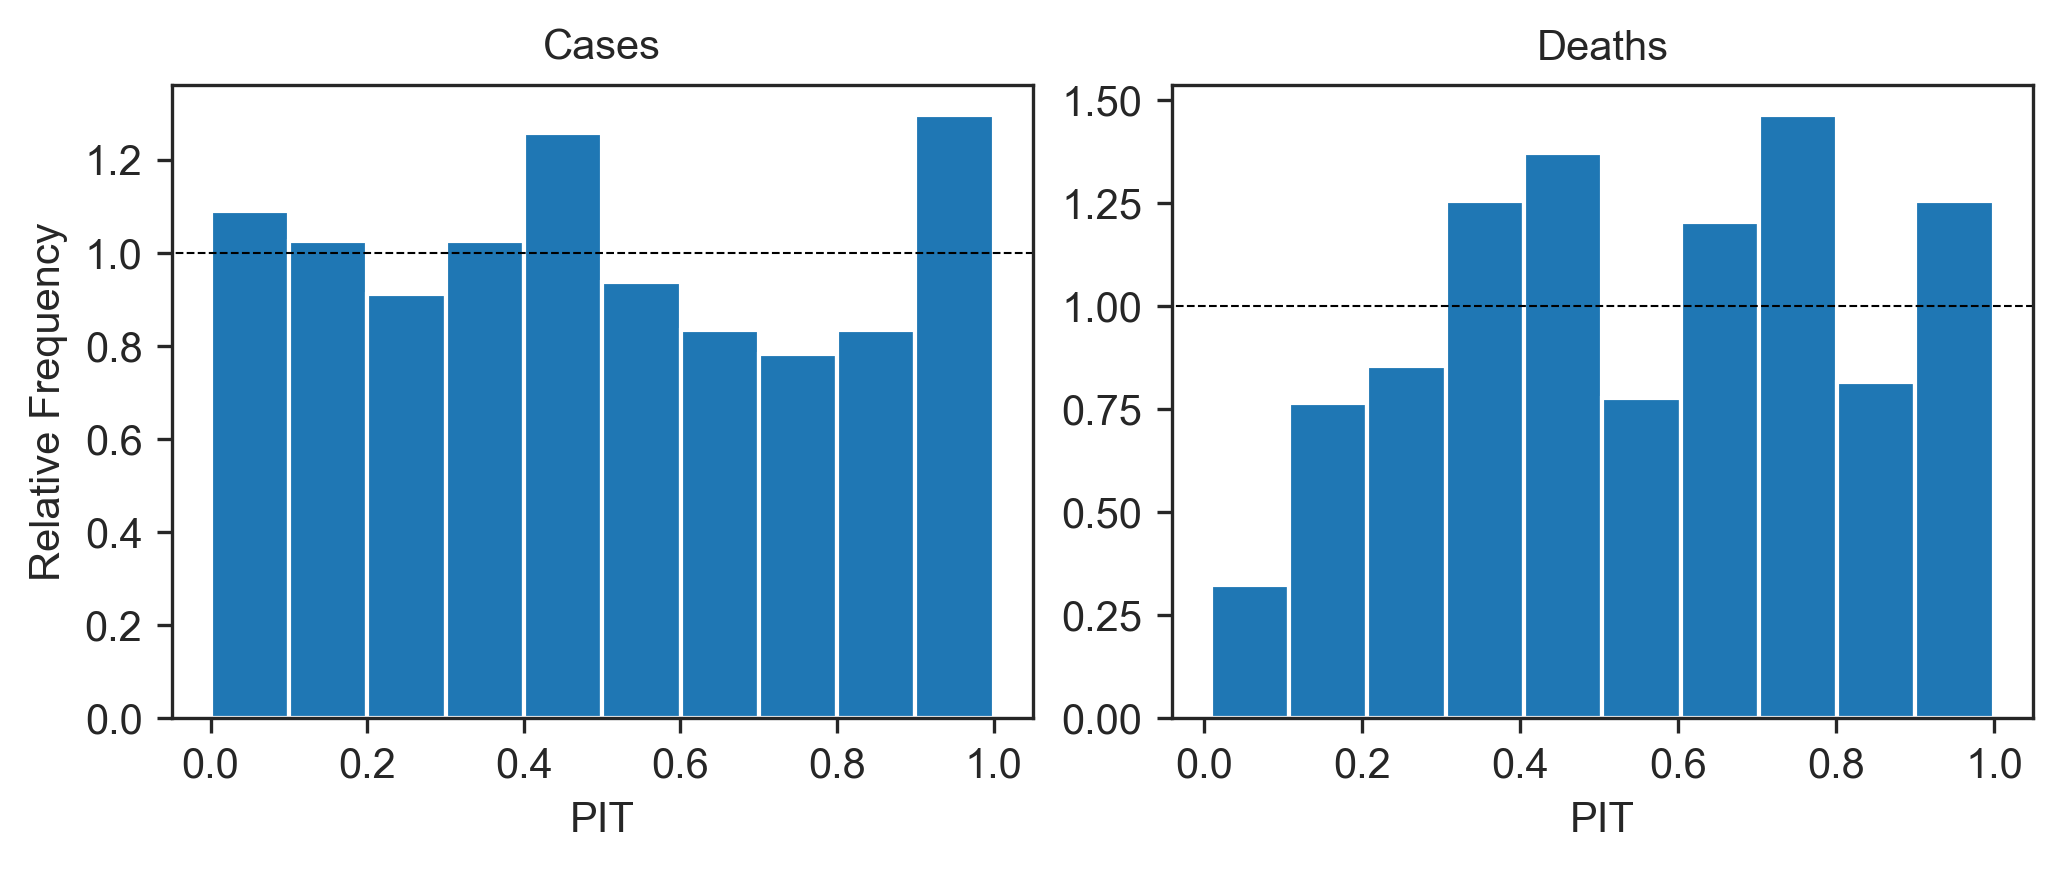

In [21]:
plt.figure(figsize=(7, 3), dpi=300)
plt.subplot(121)
plt.hist(cdf_vals_cases, bins=10, density=True)
plt.title('Cases', fontsize=10)
plt.xlabel('PIT', fontsize=10)
plt.ylabel('Relative Frequency')
plt.xlim(plt.xlim())
plt.plot([-1, 2], [1, 1], 'k--', linewidth=0.5)

plt.subplot(122)
plt.hist(cdf_vals_deaths, bins=10, density=True)
plt.title('Deaths', fontsize=10)
plt.xlabel('PIT', fontsize=10)
plt.xlim(plt.xlim())
plt.plot([-1, 2], [1, 1], 'k--', linewidth=0.5)

plt.tight_layout()
plt.savefig('PIT_sep_agg.pdf', bbox_inches='tight')

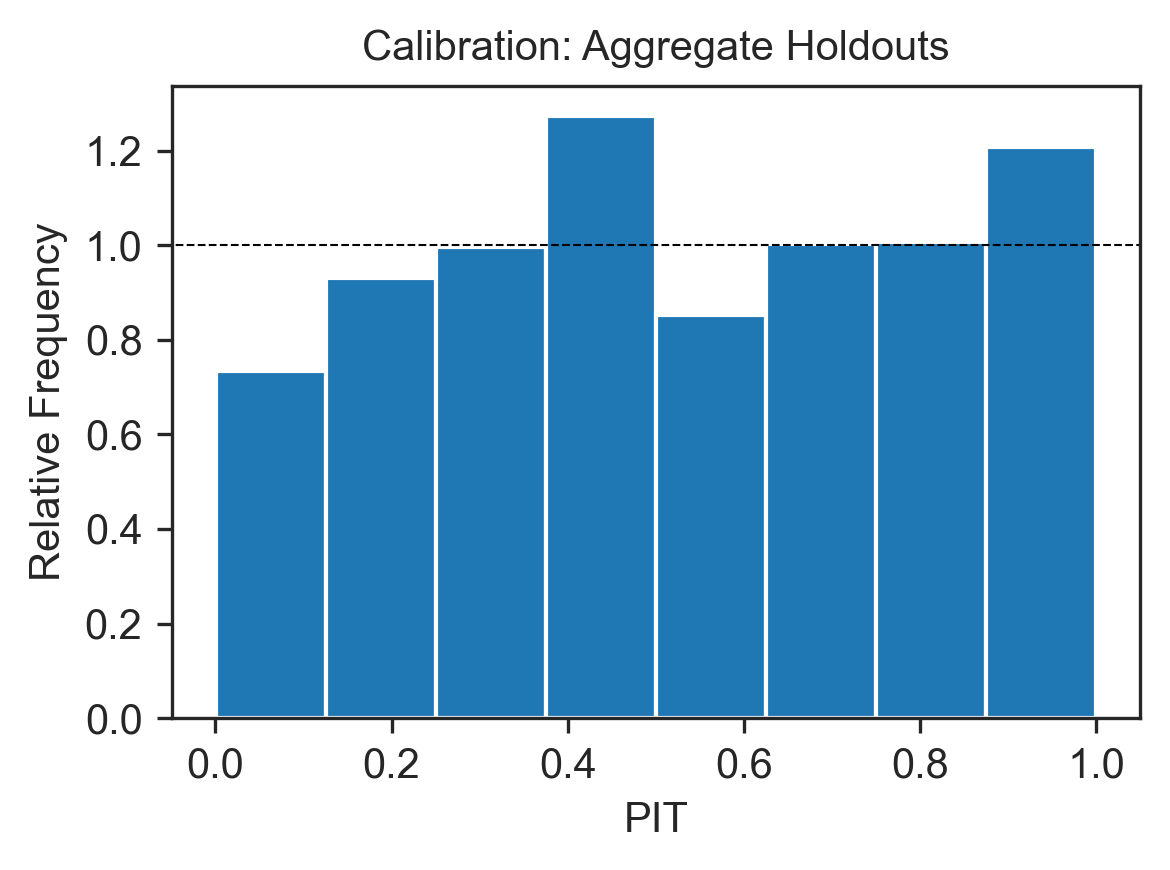

In [26]:
plt.figure(figsize=(4, 3), dpi=300)
all_cdf_vals = np.array(cdf_vals_cases)
all_cdf_vals = np.append(all_cdf_vals, cdf_vals_deaths)
plt.hist(all_cdf_vals, bins=8, density=True)
plt.title('Calibration: Aggregate Holdouts', fontsize=10)
plt.xlabel('PIT', fontsize=10)
plt.ylabel('Relative Frequency')
plt.xlim(plt.xlim())
plt.plot([-1, 2], [1, 1], 'k--', linewidth=0.5)

plt.tight_layout()
plt.savefig('PIT_comb_agg.pdf', bbox_inches='tight')

# ranking plot

In [ ]:
from scipy.stats import rankdata

In [ ]:
for i in range(5, 10):
    np.savetxt(f"exp{i}.txt", load_exp(i).CMReduction)

In [ ]:
np.savetxt(f"exp18.txt", load_exp(18).CMReduction)

In [ ]:
np.savetxt(f"exp17.txt", load_exp(17, True).CMReduction)



In [ ]:
schools_unis_lo = load_exp(20, True).CMReduction

In [ ]:
schools_unis_lo[:, 6] = default_res[:, 6]
schools_unis_lo[:, 7] = default_res[:, 7]

In [ ]:
np.savetxt(f"exp20.txt", load_exp(17, True).CMReduction)

In [ ]:
exp_add = 1
exp_noisyr = 2
exp_diff = 3
exp_dr = 4

exp_travel = 5
exp_transport = 6
exp_int_movement = 7
exp_info = 8
exp_testing = 9

exp_schools_uni = 20

exp_active = 18
exp_death = 19

In [ ]:
pickle_res = [load_exp(exp_add).CMReduction, load_exp(exp_noisyr, local=True).CMReduction, load_exp(exp_diff).CMReduction, load_exp(exp_dr).CMReduction, 
           load_exp(exp_travel).CMReduction, load_exp(exp_transport).CMReduction, load_exp(exp_int_movement).CMReduction, load_exp(exp_info).CMReduction, 
           load_exp(exp_testing).CMReduction, load_exp(exp_active).CMReduction, load_exp(exp_death).CMReduction,
           load_exp(17, True).CMReduction]

In [ ]:
for r_i, r in enumerate(data.Rs):
    res = pickle.load(open(f"../../server/ho_results_final4/{r}.pkl", "rb")).CMReduction
    np.savetxt(f"regholdout{r}.txt", res)

In [ ]:
ho_res = [pickle.load(open(f"../../server/ho_results_final4/{r}.pkl", "rb")) for r in data.Rs]

In [ ]:
extra_exps = [exp]

In [ ]:
from collections import defaultdict

nCMs = 9

def grab_all_rankings(fname, verbose=False):
    global default_res
    
    files_found = 0
    all_ranks = []
    all_names = []
    cat_sen = defaultdict(list)
    for i, (dirpath, dirnames, filenames) in enumerate(walk(fname)):
        for f in filenames:
            if ("_combined" in f or "exp" in f or "regholdout" in f) and ".txt" in f and "rhat" not in f and "ess" not in f and "base" not in f:
                trace = np.loadtxt(dirpath+"/"+f)
                nS, f_nCMs = trace.shape
                
                if f_nCMs > nCMs:
                    trace = trace[:, :nCMs]
                elif f_nCMs < nCMs:
                    leaveout_num = int(f[-5])
                    full_trace = np.zeros((nS, nCMs))
                    full_trace[:, :leaveout_num] = trace[:, :leaveout_num]
                    full_trace[:, leaveout_num] = default_res[:, leaveout_num]
                    full_trace[:, leaveout_num] = np.ones(nS)
                    full_trace[:, (leaveout_num+1):] = trace[:, leaveout_num:]
                    trace = full_trace
                
                files_found += 1
                
                res = trace
                nS, _ = res.shape
                
                nF = len(derived_features)
                derived_samples = np.zeros((nS, nF))
                all_names.append(f)
                for f_i, (f, prodrows) in enumerate(derived_features):
                    samples = np.ones(nS)
                    for r in prodrows:
                        samples = samples * res[:, r] 
                    derived_samples[:, f_i] = samples

                res = derived_samples
                ranks = rankdata(np.median(res, axis=0), method="min")
                all_ranks.append(ranks)
      
    return all_ranks, all_names

In [ ]:
all_ranks, all_names = grab_all_rankings("../../server/traces")

In [ ]:
rank_mat = np.array(all_ranks)

In [ ]:
nT, nCMs = rank_mat.shape
freq_mat = np.zeros((nCMs, nCMs))

for cm in range(nCMs):
    for rank in range(nCMs):
        freq_mat[cm, rank] = np.sum(rank_mat[:, cm] == (rank+1)) /  nT

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import PercentFormatter

plt.figure(figsize=(4, 3), dpi=300)
im = plt.imshow(100*freq_mat, vmin=0, vmax=100)
plt.xticks(np.arange(nCMs), np.arange(nCMs)+1, fontsize=8)
plt.xlabel("NPI Median Effectiveness Ranking")

ax = plt.gca()
plt.yticks(np.arange(nCMs), [f"{f[0]}" for f in derived_features], fontsize=8, ha="left")
yax = ax.get_yaxis()
yax.set_tick_params(pad=140)


for cm in range(len(derived_features)):
    for i, val in enumerate(derived_features[cm][1]):
        plt.text(8+0.6*i, cm, cm_plot_style[val][0], horizontalalignment='center', verticalalignment='center',
                     fontproperties=fp2, fontsize=8, color=cm_plot_style[val][1], zorder=-i, alpha = 1) 

ax.invert_xaxis()
plt.title("Global NPI Rank Stability", fontsize=10)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbr = plt.colorbar(im, cax=cax, format=PercentFormatter())
ax = plt.gca()
ax.tick_params(axis="both", which="major", labelsize=6)
cbr.set_ticks([25, 50, 75, 100])
plt.savefig(f"FigureGlobalStability.pdf", bbox_inches='tight')

In [ ]:
rank_mat.shape

In [ ]:
all_names

In [ ]:
def categorise_names(names):
    cs = defaultdict(lambda: 0)

    for f in names:
        if "regholdout" in f:
            cs["region holdouts"] += 1
        
        if "cm_prior" in f:
            cs["npi priors"] += 1
        
        if "min_deaths" in f:
            cs["death threshold"] += 1
        
        if "delay_mean_confirmed" in f:
            cs["delay confirmation"] += 1
        
        if "smoothing" in f:
            cs["smoothing"] += 1
        
        if "growth_noise" in f:
            cs["hypers"] += 1
            
        if "leavout" in f or "exp20" in f:
            cs["leavouts"] += 1
            
        if "serial_int" in f:
            cs["gis"] += 1
            
        if "min_confirmed" in f:
            cs["conf threshold"] += 1
            
        if "delay_mean_death" in f:
            cs["death delay"] += 1
            
        if "R_hyperprior" in f:
            cs["R hyper"] += 1   
        
        if "exp02" in f or "exp01" in f or "exp03" in f or "exp04" in f:
            cs["struct sens"] += 1
            
        if "exp5" in f or "exp6" in f or "exp7" in f or "exp8" in f or "exp9" in f:
            cs["oxcgrt checks"] += 1
            
        if "exp18" in f or "exp19" in f:
            cs["data source"] += 1
        
        if "exp17" in f:
            cs["agg holdout"] += 1
        
        
        
    return cs

In [ ]:
vals = categorise_names(all_names)

In [ ]:
for k, v in vals.items():
    print(f"{k}: {v}")

In [ ]:
np.sum(list(vals.values()))

In [ ]:
list(vals.values())